generate data for std 0.32


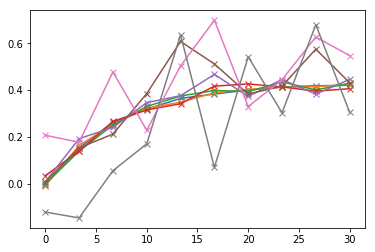

In [16]:
import pyabc
from study_abc_noise.model import ConversionReactionModelVars as ModelVars
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
%matplotlib inline

# for debugging
for module in ['Distance', 'Acceptor', 'Epsilon']:
    logger = logging.getLogger(module)
    logger.setLevel(logging.DEBUG)
    fh = logging.FileHandler('log/logger.log')
    fh.setLevel(logging.DEBUG)
    logger.addHandler(fh)

arr_std = [0.0025, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]

# create data
for std in arr_std:
    fn = f"data/data_{std}"
    mv = ModelVars(n_t=10)
    mv.noise_std = std
    if not os.path.isfile(fn + '.npy'):
        print(f"generate data for std {std}")
        data = mv.generate_data()
        np.save(fn, data['y'])
    data = np.load(fn + '.npy')
    plt.plot(mv.get_ts(), data, 'x-')

In [17]:
# proposed method

for std in arr_std:
    mv = ModelVars(n_t=10)
    mv.noise_std = std
    fb = f"cr_{std}_stochacc"
    print(fb)
    if os.path.isfile(f"{fb}.db"):
        continue
    abc = pyabc.ABCSMC(
        models=mv.get_model(),
        parameter_priors=mv.get_prior(),
        distance_function=mv.get_kernel(),
        eps=pyabc.Temperature(log_file=f"log/log_temperature_{fb}.json"),
        acceptor=pyabc.StochasticAcceptor(log_file=f"log/log_acceptor_{fb}.json"),
        population_size=1000,
        sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=10)
    )
    data = {'y': np.load(f"data/data_{std}.npy")}
    abc.new(f"sqlite:///{fb}.db", data)
    abc.run(min_acceptance_rate=1e-3)
    print()

cr_0.0025_stochacc
cr_0.005_stochacc
cr_0.01_stochacc
cr_0.02_stochacc
cr_0.04_stochacc
cr_0.08_stochacc
cr_0.16_stochacc
cr_0.32_stochacc


INFO:History:Start <ABCSMC(id=1, start_time=2019-12-22 00:07:02.423387, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=2.4416e-01 for t=0.
DEBUG:Epsilon:Proposed temperatures for 0: [1.954402766460444].
INFO:ABC:t: 0, eps: 1.954402766460444.
DEBUG:Acceptor:Encountered pd=2.5016e-01 > c=2.4416e-01, thus weight=1.0031e+00.
DEBUG:Acceptor:Encountered pd=2.5407e-01 > c=2.4416e-01, thus weight=1.0051e+00.
INFO:ABC:Acceptance rate: 1000 / 3474 = 2.8785e-01, ESS=1.0000e+03.
DEBUG:Acceptor:pdf_norm=2.5407e-01 for t=1.
DEBUG:Epsilon:Proposed temperatures for 1: [1.1125758742775522, 0.977201383230222].
INFO:ABC:t: 1, eps: 1.0.
DEBUG:Acceptor:Encountered pd=2.6064e-01 > c=2.5407e-01, thus weight=1.0066e+00.
DEBUG:Acceptor:Encountered pd=2.5980e-01 > c=2.5407e-01, thus weight=1.0057e+00.
INFO:ABC:Acceptance rate: 1000 / 3536 = 2.8281e-01, ESS=8.5861e+02.
DEBUG:Acceptor:pdf_norm=2.6064e-01 for t=2.
DEBUG:Epsilon:Proposed temperatures for 2: [1.0, 0.5].
INFO:ABC:Stop

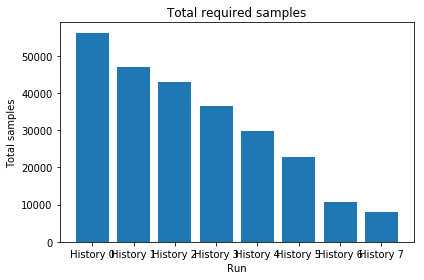

In [18]:
hs = [pyabc.History(f"sqlite:///cr_{std}_stochacc.db") for std in arr_std]
pyabc.visualization.plot_total_sample_numbers(hs)